In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import torchio as tio
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import GaussianBlur as gauss
from tqdm import tqdm
from datetime import datetime
import copy

import sys, os
sys.path.append(os.path.dirname('../.'))
from scripts.utils import print_img, print_imgs, get_path
from scripts.integral_volume import (Point3d, IntegralVol, IntegralVolTest)
from scripts.niblack3d import Niblack3d
from scripts.multyprocess_utils import MultuProcCalc
from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
                                   load_nii_vol, save_vol_as_nii, raw2nifti)

from connect import get_connected, get_all_trees

In [3]:
path_to_vol = "/home/msst/IXI_MRA_work/IXI228/IXI228_head.nii.gz"
path_to_seg = '/home/msst/IXI_MRA_work/IXI228/HessNet_isotropic_my_start_scale_30_09_2023_17:42.nii.gz'
path_to_GT = '/home/msst/IXI_MRA_work/IXI228/Unet3d_16ch_26_09_2023_22:46.nii.gz'

vol = tio.ScalarImage(path_to_vol)
seg = tio.ScalarImage(path_to_seg)
GT = tio.ScalarImage(path_to_GT)

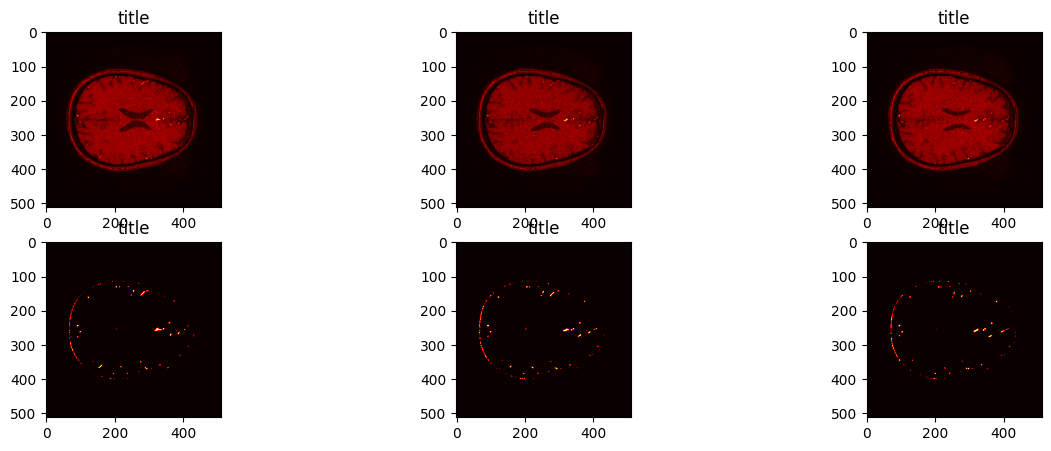

In [4]:
for i in range(20, 21): #(6, 7):
    fig, ax = plt.subplots(2, 3, figsize=(15,5))
    print_img(vol.data[0], axis=ax[0][0], slice_=10+3*i, bar=False)
    print_img(vol.data[0], axis=ax[0][1], slice_=10+3*i+1, bar=False)
    print_img(vol.data[0], axis=ax[0][2], slice_=10+3*i+2, bar=False)
    
    print_img(seg.data[0], axis=ax[1][0], slice_=10+3*i, bar=False)
    print_img(seg.data[0], axis=ax[1][1], slice_=10+3*i+1, bar=False)
    print_img(seg.data[0], axis=ax[1][2], slice_=10+3*i+2, bar=False)

**<h4> Connected Areas** 

torch.Size([200, 200, 25])


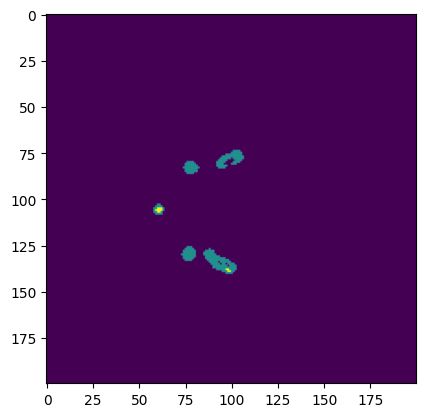

In [14]:
img = vol.data[0][150:350, 200:400, 10:35]#[200:300, 250:350, 29]#
#g = gauss(5, sigma=[1, 1])
#img = g(img.unsqueeze(0))[0]
plt.imshow(img[:, :, 0])
print(img.shape)

img_min, img_max = img.min(), img.max()
C = 3
delta = (img_max-img_min)/C

image = torch.zeros_like(img)
for i in range(C):
    image[(img<img_min+(i+1)*delta)*(img>=img_min+(i)*delta)] = i
    
plt.imshow(image[:, :, 0])

In [15]:
# image = torch.randn(15, 15, 1)
# T = 0.3
# image[image<T] = 0
# image[image>0] = 1
# plt.imshow(image[:, :, 0])

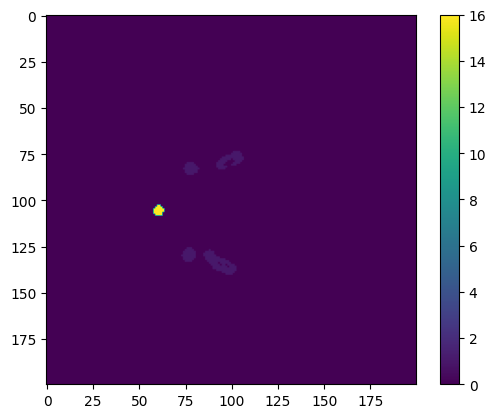

In [19]:
label_img, dict_of_equal = get_connected(image)
im = plt.imshow(label_img[:, :, 0])
plt.colorbar(im)
#dict_of_equal

In [23]:
out = get_all_trees(dict_of_equal)
#out

In [24]:
len(out)

22

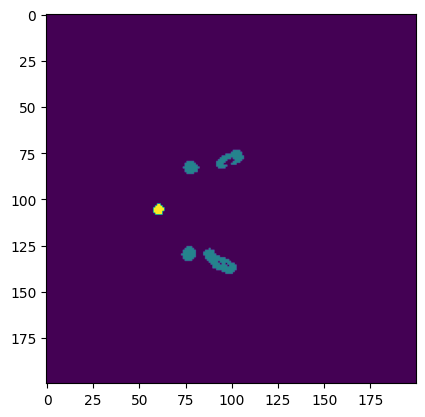

In [25]:
new_vol = np.zeros_like(label_img)
for new_label, comp in enumerate(out):
    for label in comp:
        new_vol[label_img==label]=new_label+1
        
plt.imshow(new_vol[:, :, 0]**0.5)

<BarContainer object of 80 artists>

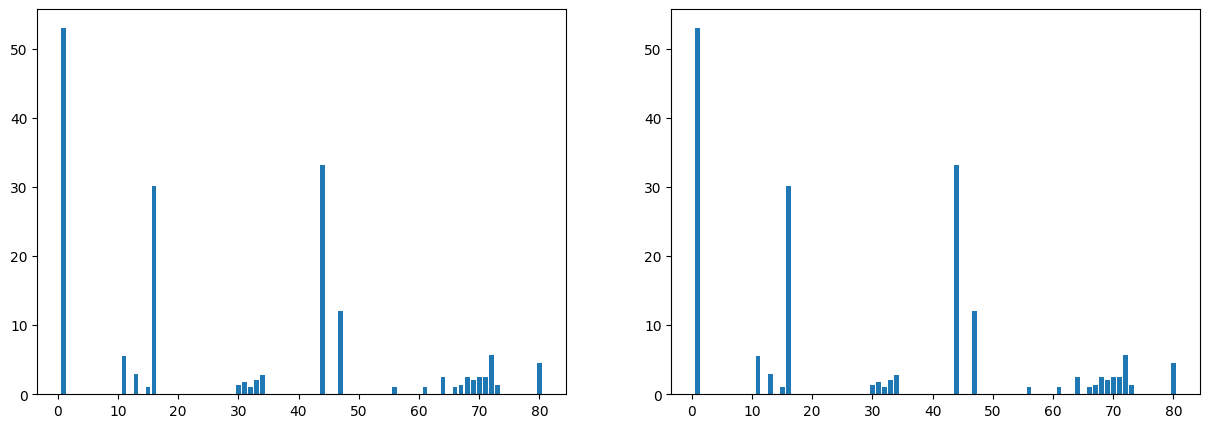

In [13]:
MIN_SIZE = 0

x = np.linspace(1, label_img.max(), label_img.max())
y_ = np.zeros_like(x)
y = np.zeros_like(x)
for idx, comp in enumerate(x):
    y_[idx] = len(np.where(label_img==comp)[0])
    y[idx] = y_[idx]*1
    if y[idx] < MIN_SIZE:
        label_img[label_img==comp]=0
        y[idx]=0

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].bar(x, y_**0.5)
ax[1].bar(x, y**0.5)

In [26]:
path_to_save_small_img = f"/home/msst/IXI_MRA_work/IXI228/TEST/COMPONENT_SMALLIMG.nii.gz"
path_to_save_new_labels = f"/home/msst/IXI_MRA_work/IXI228/TEST/COMPONENT_new_seg.nii.gz"
path_to_save_labels = f"/home/msst/IXI_MRA_work/IXI228/TEST/COMPONENT_seg.nii.gz"

save_vol_as_nii(image, vol.affine, path_to_save_small_img)
save_vol_as_nii(new_vol, vol.affine, path_to_save_new_labels)
save_vol_as_nii(label_img, vol.affine, path_to_save_labels)

**<h4> SmartIntegral Image** 

In [18]:
class SmartIntegralImage:
    def __init__(self, vol, seg, window_size=(5, 5, 5)):
        assert vol.shape==seg.shape
        self.shape = vol.shape
        tmp = vol*1
        tmp[seg==0] = 0
        self.img_vol = tmp
        self.seg_vol = seg
        self.int_vol = IntegralVol(tmp)
        self.int_seg = IntegralVol(seg)
        self.window_size = window_size
        self.w_st = (window_size[0]//2,
                     window_size[1]//2,
                     window_size[2]//2) 
    
    def get_mean(self, point):
        if self.seg_vol[point.x, point.y, point.z]:
            point1 = Point3d(point.x-self.w_st[0],
                             point.y-self.w_st[1],
                             point.z-self.w_st[2]).edit_to_shape(self.shape)
            point2 = Point3d(point.x+self.w_st[0],
                             point.y+self.w_st[1],
                             point.z+self.w_st[2]).edit_to_shape(self.shape)
            sum_ = self.int_vol.calculate_sum(point1, point2)
            N = self.int_seg.calculate_sum(point1, point2)
            return(sum_/N)
        else:
            return(0)   
    
    def get_smart_avg(self):
        smart_avg_img3d = np.zeros(self.shape)
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                for k in range(self.shape[2]):
                    smart_avg_img3d[i, j, k] = self.get_mean(Point3d(i, j, k))
        return(smart_avg_img3d)

In [19]:
#torch tensor to np.array
img3d = vol.data[0].numpy()
seg3d = seg.data[0].numpy()
GT3d = GT.data[0].numpy()

img3d = img3d[150:350, 100:250]
seg3d = seg3d[150:350, 100:250]
GT3d = GT3d[150:350, 100:250]

#create SmartIntegralImage object
smart_img = SmartIntegralImage(img3d, seg3d, window_size=(11, 11, 5))
smart_avg_img3d = smart_img.get_smart_avg()

In [20]:
def ProcessPoint(image, smart_avg_img, x, y, z, C, wings):
    img3x3x2 = smart_avg_img[x-wings[0]:x+wings[0]+1,
                             y-wings[0]:y+wings[0]+1,
                             z-wings[0]:z+wings[0]]
    vals = img3x3x2[np.where(img3x3x2>0)]
    if len(vals)==0:
        return 0
    else:
        if image[x, y, z]>C*(vals.sum()/len(vals)):
            return image[x, y, z]
        else:
            return 0


def SingleIteration(image, smart_avg_img, C=0.99, wings = 3*(2,)):
    out = smart_avg_img*1
    for x in range(wings[0], image.shape[0]):
        for y in range(wings[1], image.shape[1]):
            for z in range(wings[2], image.shape[2]):
                if out[x, y, z] == 0:
                    out[x, y, z] = ProcessPoint(image, out, x, y, z, C=C, wings=wings)
    return(out)

In [21]:
n_iters = 3
C = 0.95
wings = 3*(1,)

smart_avg_img3d_proc = smart_avg_img3d*1
for it in tqdm(range(n_iters)):
    smart_avg_img3d_proc = SingleIteration(img3d, smart_avg_img3d_proc, C=C, wings=wings)
    print(smart_avg_img3d_proc.sum()/smart_avg_img3d.sum())

 33%|███████████████                              | 1/3 [00:08<00:16,  8.27s/it]

1.0365902336484003


 67%|██████████████████████████████               | 2/3 [00:16<00:08,  8.29s/it]

1.0409514298185671


100%|█████████████████████████████████████████████| 3/3 [00:24<00:00,  8.26s/it]

1.0424121272066278


In [22]:
model_name = 'TEST'
dt_string = datetime.now().strftime("%d_%m_%Y_%H:%M")
dir_name = os.path.dirname(path_to_vol)

path_to_save_SEG = f"/home/msst/IXI_MRA_work/IXI{sample_index}/TEST/{model_name}_{dt_string}_GT.nii.gz"
path_to_save_IMG = f"/home/msst/IXI_MRA_work/IXI{sample_index}/TEST/{model_name}_{dt_string}_IMG.nii.gz"
path_to_save_SMART_IMG = f"/home/msst/IXI_MRA_work/IXI{sample_index}/TEST/{model_name}_{dt_string}_SMART_IMG.nii.gz"
path_to_save_SMART_IMG_PROC = f"/home/msst/IXI_MRA_work/IXI{sample_index}/TEST/{model_name}_{dt_string}_SMART_IMG_PROC.nii.gz"

save_vol_as_nii(GT3d>0, vol.affine, path_to_save_SEG)
save_vol_as_nii(img3d, vol.affine, path_to_save_IMG)
save_vol_as_nii(smart_avg_img3d>0, vol.affine, path_to_save_SMART_IMG)
save_vol_as_nii(smart_avg_img3d_proc>0, vol.affine, path_to_save_SMART_IMG_PROC)

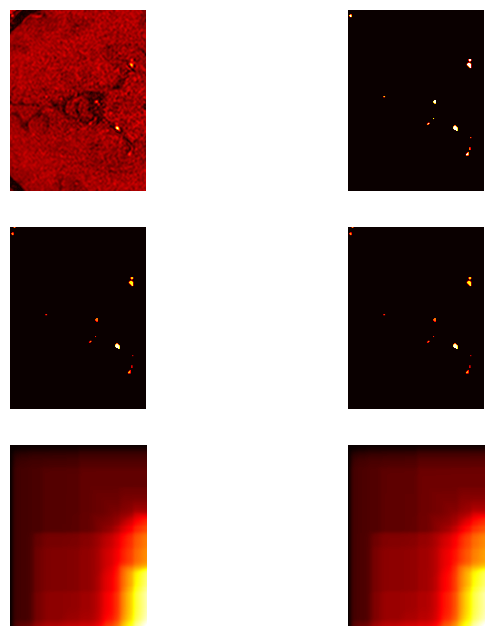

In [52]:
slice = 29
N1, N2 = 3, 2
fig, ax = plt.subplots(N1, N2, figsize=(8,8))
im1 = ax[0][0].imshow(img3d[:, :, slice], cmap="hot")
im2 = ax[0][1].imshow(seg3d[:, :, slice], cmap="hot")
im3 = ax[1][0].imshow(smart_avg_img3d[:, :, slice], cmap="hot")
im4 = ax[1][1].imshow(smart_avg_img3d_proc[:, :, slice], cmap="hot")
im5 = ax[2][0].imshow(smart_img.int_vol.integral_vol[:, :, slice+1], cmap="hot")
im5 = ax[2][1].imshow(smart_img.int_seg.integral_vol[:, :, slice+1], cmap="hot")

#plt.colorbar(im1)
#plt.colorbar(im2)


for x in range(N1):
    for y in range(N2):
        ax[x, y].axis('off')